In [1]:
from astropy.table import QTable
from astropy.table import vstack
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

icat = 'EMUSim2x2'
injected = {
    'sim': QTable.read('sim_2x2/xtables/emu_simulated_2x2.hydra.emusim2x2.external_catalogue.fits'),
    'ext': QTable.read('ext_2x2/xtables/emu_simulated_ext2x2.hydra.emusim2x2.external_catalogue.fits'),
}
cluster = {
    'sim': QTable.read('sim_2x2/xtables/emu_simulated_2x2.hydra.cluster_catalogue.fits'),
    'ext': QTable.read('ext_2x2/xtables/emu_simulated_ext2x2.hydra.cluster_catalogue.fits'),
    'emu': QTable.read('emu_2x2/xtables/emu_pilot_sample_2x2deg.hydra.cluster_catalogue.fits'),
    #'4x4': QTable.read('emu_4x4/xtables/emu_pilot_sample_4x4deg.hydra.cluster_catalogue.fits')
}
for run in cluster:
    cluster[run].add_column(
        name = 'eccentricity',
        col = np.sqrt(1-(cluster[run]['extent_semiminor']/cluster[run]['extent_semimajor'])**2)
    )
    if run in injected:
        cluster[run].add_column(
            name = 'injected',
            col = -1000.0*np.ones(len(cluster[run]))*u.mJy
        )

        cluster[run].add_column(
            name = 'sn_injected',
            col = -1000.0*np.ones(len(cluster[run]))
        )

        for cat_id in np.unique(cluster[run][(cluster[run]['source_finder']==icat)]['cat_id']):
            flux_in = injected[run][(injected[run]['id']==cat_id)]['flux_total'][0]
            sn_deep = (flux_in/injected[run][(injected[run]['id']==cat_id)]['rms_noise_bane_deep'][0]).value
            sn_shallow = (flux_in/injected[run][(injected[run]['id']==cat_id)]['rms_noise_bane_shallow'][0]).value
            match_id = cluster[run][((cluster[run]['source_finder']==icat)&(cluster[run]['cat_id']==cat_id))]['match_id'][0]
            ref_ids = cluster[run][(cluster[run]['match_id']==match_id)]['ref_id']
            for ref_id in ref_ids:
                match = cluster[run]['ref_id']==ref_id
                cluster[run]['injected'][match] = flux_in
                if cluster[run][match]['image_type']=='deep':
                    cluster[run]['sn_injected'][match]= sn_deep
                else:
                    cluster[run]['sn_injected'][match]= sn_shallow

s_map = {
    'sim': 'pts',
    'ext': 'ext',
    'vls': 'vlass',
    'emu': 'emu',
}
source_finders = np.unique(cluster['sim'][(cluster['sim']['source_finder']!=icat)]['source_finder']).tolist()
colors = {
    'aegean': 'green',
    'caesar': 'magenta',
    'profound': 'red',
    'pybdsf': 'orange',
    'selavy': 'blue',
    icat: 'black',
}
labels = {
    'aegean': 'Aegean',
    'caesar': 'Caesar',
    'profound': 'ProFound',
    'pybdsf': 'PyBDSF',
    'selavy': 'Selavy',
    icat: 'Simulated',
}

print("[DONE]")


[DONE]


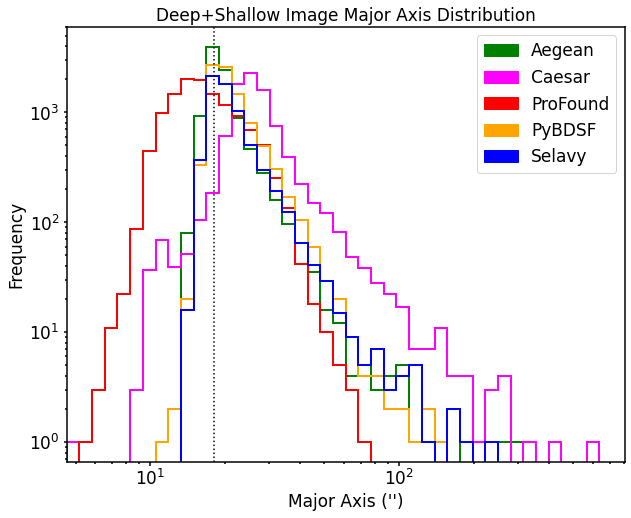

In [49]:

def maj_plot(tag,depth=None,is_save=False):
    e_axis = 'extent_semimajor'
    #e_axis = 'extent_semiminor'
    
    # axis limits
    r_min = 2.0*np.min(cluster[tag][(cluster[tag]['source_finder']!=icat)][e_axis].to(u.arcsec).value)
    r_max = 2.0*np.max(cluster[tag][(cluster[tag]['source_finder']!=icat)][e_axis].to(u.arcsec).value)
    
    # do histogram
    qt_sim = cluster[tag]
    fig = plt.figure(figsize=(10,8))
    kwargs = {
        'histtype': 'stepfilled',
        'facecolor': 'None',
        'bins': np.logspace(np.log10(r_min),np.log10(r_max),45),
        'linewidth': 2,
    }
    kwargy = kwargs.copy()
    kwargy['facecolor'] = 'grey'
    kwargy['alpha'] = 0.5
    for source_finder in source_finders+[icat]:
        if depth is None:
            qt = qt_sim[(qt_sim['source_finder']==source_finder)]
        else:
            qt = qt_sim[((qt_sim['image_type']==depth)&(qt_sim['source_finder']==source_finder))]
        if source_finder == icat:
            plt.hist(2.0*qt[e_axis].to(u.arcsec).value,edgecolor=colors[source_finder],**kwargy)
        else:
            if tag != 'emu':
                plt.hist((1.0 if source_finder in ['aegean','profound'] else 2.0)*qt[e_axis].to(u.arcsec).value,edgecolor=colors[source_finder],**kwargs)
            else:
                plt.hist(2.0*qt[e_axis].to(u.arcsec).value,edgecolor=colors[source_finder],**kwargs)

        
    # annotations
    fz = 17
    s_axis = 'Major' if e_axis == 'extent_semimajor' else 'Minor'
    plt.xlim((r_min,r_max))
    plt.xscale('log')
    plt.xticks(fontsize=fz)
    plt.xlabel(f"{s_axis} Axis ('')",fontsize=fz)
    plt.yscale('log')
    plt.yticks(fontsize=fz)
    plt.ylabel('Frequency',fontsize=fz)
    plt.axvline(18 if tag=='emu' else 15,color='black',linestyle=":")
    if depth is None:
        plt.title(f"Deep+Shallow Image {s_axis} Axis Distribution",fontsize=fz)
    else:
        plt.title(f"{depth.capitalize()} Image {s_axis} Axis Distribution",fontsize=fz)
    
    # adjust axis/frame thickness
    lw = 1.5
    ax = plt.gca()
    ax.tick_params(width=lw)
    ax.tick_params(which='minor',width=lw)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    
    # do legend
    cls = colors.copy()
    lbs = labels.copy()
    if tag == 'emu':
        del cls[icat]
        del lbs[icat]
    legend = {
        'handles': [mpatches.Patch(color=cls[m],label=lbs[m],alpha=0.5 if m==icat else 1.0) for m in cls],
        'framealpha': 0.85,
        'fontsize': fz,
        'loc': 'upper right' if e_axis == 'extent_semimajor' else 'upper left'
    }
    plt.legend(**legend)
        
    #plt.show() # don't use this when saving -- gives blank png file
    if is_save:
        if tag == '4x4':
            fname = f"plots/hydra_4x4_emu_{s_axis.lower()}_axis_distribution_{'deep_shallow' if depth is None else depth.lower()}_image.png"
        else:
            fname = f"plots/hydra_2x2_{s_map[tag]}_{s_axis.lower()}_axis_distribution_{'deep_shallow' if depth is None else depth.lower()}_image.png"
        print(f"Saving: {fname}")
        plt.savefig(fname)

maj_plot('emu',is_save=False)

Aegean: fr_max = 936.0 @ e = 0.13265306122448978 ± 0.010204081632653059
> for e ∈ [0.12244897959183673,0.14285714285714285]


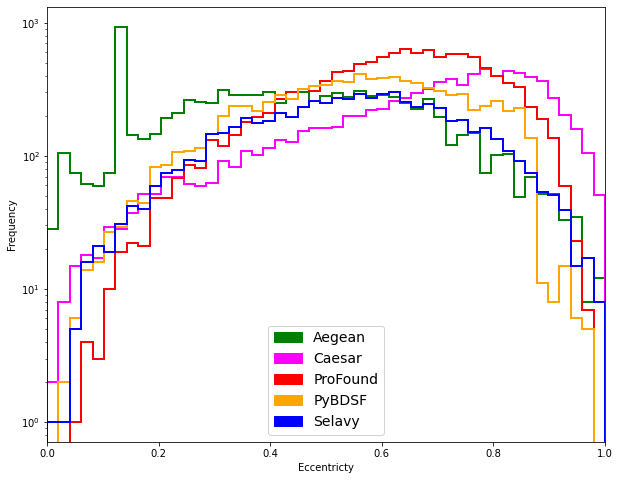

In [19]:
def e_plot(tag,depth=None,is_save=False):
    fig = plt.figure(figsize=(10,8))
    kwargs = {
        'histtype': 'stepfilled',
        'facecolor': 'None',
        'bins': np.linspace(0,1,50),
        'linewidth': 2,
    }
    kwargy = kwargs.copy()
    kwargy['facecolor'] = 'grey'
    kwargy['alpha'] = 0.5
    for source_finder in source_finders+[icat]:
        #print(source_finder)
        qt = cluster[tag][(cluster[tag]['source_finder']==source_finder)]
        x=plt.hist(qt['eccentricity'].value,edgecolor=colors[source_finder],**(kwargy if source_finder==icat else kwargs))
        if source_finder == 'aegean':
            try:
                fr_max = max(x[0])
                binl = binu = -1
                for i in range(len(x[0])):
                    if x[0][i] == fr_max:
                        binl = x[1][i]
                        binu = x[1][i+1]
                        #plt.axvline(x[1][i])
                        #plt.axvline(x[1][i+1])
                        break
                print(f"Aegean: fr_max = {fr_max} @ e = {np.mean([binl,binu])} \u00B1 {np.std([binl,binu])}")
                print(f"> for e \u2208 [{binl},{binu}]")
                #print(x)
            except:
                pass
        plt.xlim((0,1))
        plt.yscale('log')
        plt.xlabel('Eccentricty')
        plt.ylabel('Frequency')
        #plt.ylim((0,350))
    
    # do legend
    cls = colors.copy()
    lbs = labels.copy()
    if tag == 'emu':
        del cls[icat]
        del lbs[icat]
    legend = {
        'handles': [mpatches.Patch(color=cls[m],label=lbs[m],alpha=0.5 if m==icat else 1.0) for m in cls],
        'framealpha': 0.85,
        'fontsize': 14,
        'loc': 'lower center',
    }
    plt.legend(**legend)
        
e_plot('emu')


In [44]:
# let's deprecate this...
class Coincidence:
    def __int__(self,tag):
        self.tag = tag
        qt = cluster[tag]
        sfs = np.unique(qt['source_finder'])
        n_sfs = len(sfs)
        bins = dict()
        for depth in ('deep','shallow'):
            qd = qt[(qt['image_type']==depth)]
            match_ids = np.unique(qd['match_id'])
            bins[depth] = {'total': [0 for _ in range(n_sfs)]}
            for match_id in match_ids:
                qm = qd[(qd['match_id']==match_id)]
                idx = len(qm)-1
                bins[depth]['total'][idx] += 1
                for sf in sfs:
                    if not sf in bins[depth]:
                        bins[depth][sf] = [0 for _ in range(n_sfs)]
                    bins[depth][sf][idx] += len(qm[(qm['source_finder']==sf)])/len(qm)
        self.bins = bins
        self.source_finders = sfs
        self.number_of_source_finders = n_sfs
    def plot(self, depth='deep'):
        fig = plt.figure(figsize=(10,8))
        gc = plt.gca()
        plt.xlim((self.number_of_source_finders+0.55,0.45))
        plt.ylim((0,1025*max(bins[depth]['total'])/1000))
        for i in range(len(bins[depth]['total'])):
            y0 = 0
            for sf in sfs:
                hd = bins[depth][sf][i]
                gc.add_patch(Rectangle((i+0.55, y0), 0.9, hd,alpha=1, facecolor=colors[sf]))
                y0 += hd
        plt.xlabel("Coincedent Source Finder Detections")
        plt.ylabel("Frequency")




In [10]:
# need to run before calling emu_coin() below
qt = cluster['emu']
sfs = np.unique(qt['source_finder'])
n_sfs = len(sfs)
bins = dict()
for depth in ('deep','shallow'):
    qd = qt[(qt['image_type']==depth)]
    match_ids = np.unique(qd['match_id'])
    bins[depth] = {'total': [0 for _ in range(n_sfs)]}
    for match_id in match_ids:
        qm = qd[(qd['match_id']==match_id)]
        idx = len(qm)-1
        bins[depth]['total'][idx] += 1
        for sf in sfs:
            if not sf in bins[depth]:
                bins[depth][sf] = [0 for _ in range(n_sfs)]
            bins[depth][sf][idx] += len(qm[(qm['source_finder']==sf)])/len(qm)


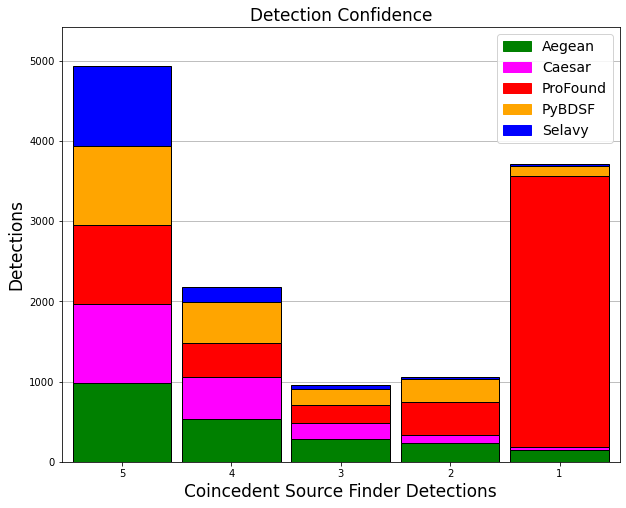

In [11]:
def emu_coin(depth = 'deep',is_save=False):
    fz=17
    fig = plt.figure(figsize=(10,8))
    gc = plt.gca()
    plt.xlim((n_sfs+0.55,0.45))
    plt.ylim((0,1100*max(bins[depth]['total'])/1000))
    for i in range(len(bins[depth]['total'])):
        y0 = 0
        sv = dict()
        for sf in sfs:
            sv[sf] = {'xy': (i+0.55, y0), 'width': 0.9, 'height': bins[depth][sf][i], 'color': colors[sf]}
            y0 += bins[depth][sf][i]
        
        # plot stacked histograms
        for sf in sfs:
            gc.add_patch(Rectangle(
                sv[sf]['xy'],
                sv[sf]['width'],
                sv[sf]['height'],
                facecolor=sv[sf]['color'],
                edgecolor='k',
                #alpha=0.75,
                zorder = 2
            ))
            
    # labels
    plt.xlabel("Coincedent Source Finder Detections",fontsize=17)
    plt.ylabel("Detections",fontsize=17)
    plt.title("Detection Confidence",fontsize=17)
    plt.grid(axis='y',which='both',zorder=1)

    # legend
    cls = colors.copy()
    lbs = labels.copy()
    del cls[icat]
    del lbs[icat]
    legend = {
        'handles': [mpatches.Patch(color=cls[m],label=lbs[m],alpha=0.5 if m==icat else 1.0) for m in cls],
        'framealpha': 0.85,
        'fontsize': 14,
        'loc': 'upper right'
    }
    plt.legend(**legend)
    
    if is_save:
        fname = f"plots/hydra_2x2_emu_{depth}_detection_confidence_chart.png"
        plt.savefig(fname)
    

emu_coin('deep',is_save=False)

In [33]:
1-0.45

0.55

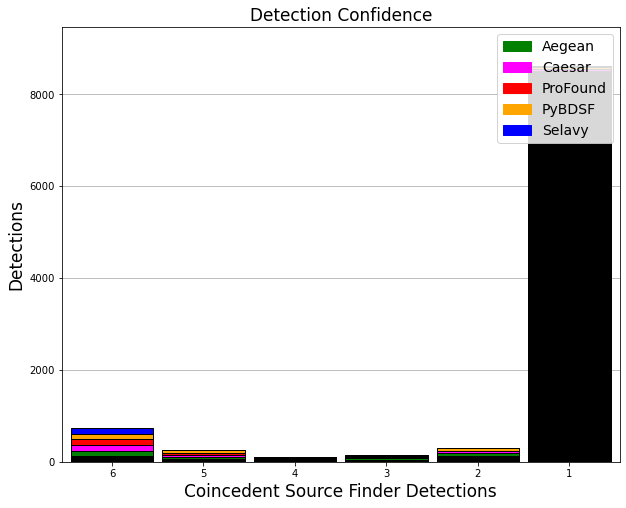

In [9]:
emu_coin('shallow',is_save=False)


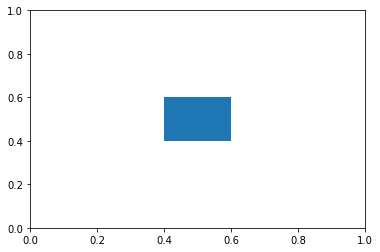

In [50]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
#https://stackoverflow.com/questions/21445005/drawing-rectangle-with-border-only-in-matplotlib
someX, someY = 0.5, 0.5
plt.figure()
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .1, someY - .1), 0.2, 0.2,alpha=1))
#plt.show()


In [127]:
# need to run before calling d_madfm() below
tag = 'emu' # not debugged for other surveys (i.e., not really needed for Hydra paper)

# fliter out non-gaussian source finders
is_filter = True
rejects = ['caesar','profound'] if is_filter else []
def get_madfms():
    qt = cluster[tag]
    qt = qt[(qt['image_type']=='deep')]
    cids = np.unique(qt['clump_id'])
    madfms = {sf: [] for sf in np.unique(qt['source_finder'])}
    for sf in rejects:
        del madfms[sf]
    sfs = list(madfms.keys())
    for cid in cids:
        clp =  qt[(qt['clump_id']==cid)]
        tmp = dict()
        for sf in sfs:
            df = clp[(clp['source_finder']==sf)]
            madfm = np.unique(df['residual_madfm'])
            if len(madfm) > 0:
                tmp[sf] = madfm[0].value
                #madfms[sf].append(madfm[0].value)
        if len(tmp)>0:
            madfm_min = {list(tmp.keys())[0]:tmp[list(tmp.keys())[0]]}
            for sf in tmp:
                if list(madfm_min.values())[0] > tmp[sf]:
                    madfm_min = {sf:tmp[sf]}
            madfms[list(madfm_min.keys())[0]].append(list(madfm_min.values())[0])
    return madfms

madfms = get_madfms()

In [41]:
for sf in madfms:
    madfm = madfms[sf]
    print(f"{sf}: {np.mean(madfm):.2e}"+"\u00B1"+f"{np.std(madfm):.2e} on [{np.min(madfm):.2e}, {np.max(madfm):.2e}]")


aegean: 8.40e-02±5.04e-01 on [1.32e-04, 3.43e+01]
caesar: 1.39e-03±5.24e-03 on [0.00e+00, 7.10e-02]
profound: 3.06e-04±2.83e-03 on [0.00e+00, 1.43e-01]
pybdsf: 1.02e-01±1.23e+00 on [1.34e-04, 7.07e+01]
selavy: 5.61e-02±2.05e-01 on [1.44e-04, 9.61e+00]


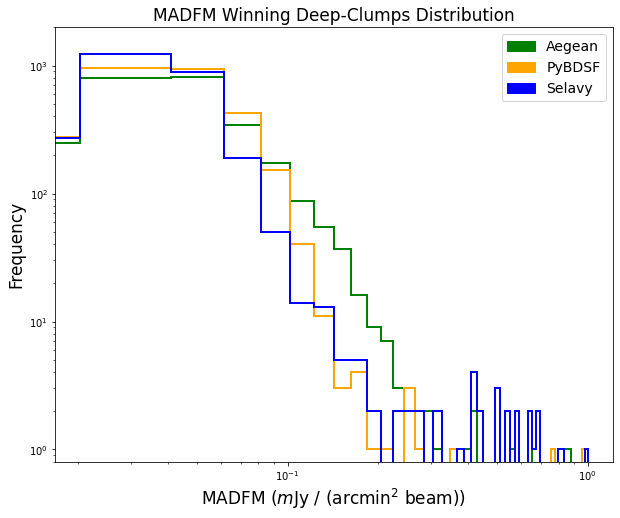

In [129]:
def d_madfm(is_save=False):
   # Global Residual for EMU 2x2 sample
    # nb: too small to show on plot scale
    gb_madfms = { # EMU Deep
        'aegean':   2.60E-05,
        'caesar':   2.30E-05,
        'profound': 1.90E-05,
        'pybdsf':   2.60E-05,
        'selavy':   2.70E-05,
    }
    # hist plot
    fig = plt.figure(figsize=(10,8))
    kwargs = {
        'histtype': 'stepfilled',
        'facecolor': 'None',
        'bins': np.linspace(0,1,50),
        'linewidth': 2,
    }
    kwargy = kwargs.copy()
    kwargy['facecolor'] = 'grey'
    kwargy['alpha'] = 0.5
    #plt.xlim((.02,.1))
    handles = list()
    for sf in madfms:
        if not sf in rejects:
            plt.hist(madfms[sf],edgecolor=colors[sf],**kwargs)
            handles.append(mpatches.Patch(color=colors[sf],label=labels[sf],alpha=1.0))
            #plt.axvline(gb_madfms[sf],color=colors[sf],linestyle=":")
            
    # plot aesthetics 
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim((.8,2000) if is_filter else (.8,2*10**4))
    plt.ylabel('Frequency',fontsize=17)
    plt.xlabel('MADFM ($m$Jy / (arcmin$^2$ beam))',fontsize=17)
    plt.title("MADFM Winning Deep-Clumps Distribution",fontsize=17)

    # legend
    legend = {
        #'handles': [mpatches.Patch(color=colors[sf],label=labels[sf],alpha=1.0) for sf in madfms],
        'handles': handles,
        'framealpha': 0.85,
        'fontsize': 14,
        'loc': 'upper right'
    }
    plt.legend(**legend)

    if is_save and tag == 'emu':
        if is_filter:
            fname = 'plots/hydra_2x2_emu_deep_clump_madfm_wins_distribution_gaussian_sf_only.png'
        else:
            fname = 'plots/hydra_2x2_emu_deep_clump_madfm_wins_distribution_non_gaussian_sf_included.png'
        print(f"SAVING: {fname}")
        plt.savefig(fname)


    

d_madfm()       

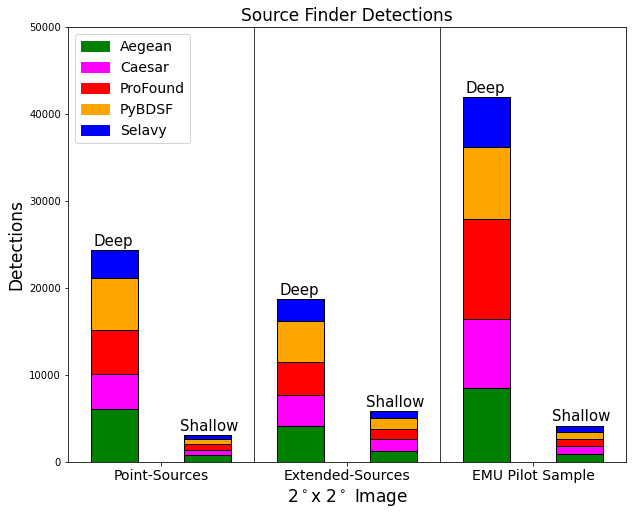

In [168]:
# dataset: point (pts), extended (ext), and EMU (emu) detection stats
finders = ['aegean','caesar','profound','pybdsf','selavy']
n_pts = {'deep': [6016,4084, 4997,5991,3225], 'shallow': [ 747, 657, 642, 598,427]}
n_ext = {'deep': [4112,3618, 3730,4688,2544], 'shallow': [1287,1297,1138,1312,787]}
n_emu = {'deep': [8538,7838,11484,8292,5800], 'shallow': [ 926, 885, 778, 794,789]}
pars = {'Points': n_pts, 'Extended': n_ext, 'EMU': n_emu}


# nomorlize dectections, globally
is_norm = False
if is_norm:
    for sim in pars:
        for depth in pars[sim]:
            total = np.sum(pars[sim][depth])
            pars[sim][depth] = [n*100/total for n in pars[sim][depth]]

def d_detect(is_save=False):
    # do the stack plots
    w=0.25
    offset = {'deep': 0, 'shallow': 0.5}
    n_sim = {'Points': 0.5, 'Extended': 1.5, 'EMU': 2.5}
    fig = plt.figure(figsize=(10,8))
    gc = plt.gca()
    for depth in ['deep','shallow']:
        for par in pars:
            sim = pars[par][depth].copy()
            for i in range(len(sim)):
                y0 = 0
                sv = dict()
                for j in range(len(finders)):
                    sf = finders[j]
                    sv[sf] = {'xy': (n_sim[par]-0.25-w/2+offset[depth], y0), 'width': w, 'height': sim[j], 'color': colors[sf]}
                    y0 += sim[j]

                # plot stacked histograms
                for sf in finders:
                    gc.add_patch(Rectangle(
                        sv[sf]['xy'],
                        sv[sf]['width'],
                        sv[sf]['height'],
                        facecolor=sv[sf]['color'],
                        edgecolor='k',
                        #alpha=0.75,
                        zorder = 2
                    ))
            if not is_norm:
                plt.text(
                    n_sim[par]-0.25-w/2+offset[depth]-(-0.01 if depth=='deep' else 0.025),
                    y0+500,
                    depth.capitalize(),
                    **{'size':15}
                )

    # set axis limits
    plt.ylim((0,110) if is_norm else (0,5*10**4))
    plt.xlim((0,3))

    # annotations
    fz=17
    plt.title("Source Finder Detections",size=fz)
    plt.axvline(1,color='k',lw=0.75)
    plt.axvline(2,color='k',lw=0.75)
    plt.xlabel("$2^\circ$x$\;2^\circ$ Image",size=fz)
    plt.ylabel("Detections",size=fz)
    plt.legend(**{
        'handles': [mpatches.Patch(color=colors[m],label=labels[m],alpha=0.5 if m==icat else 1.0) for m in finders],
        'framealpha': 0.85,
        'fontsize': 14,
        'loc': 'upper left',
    })
    x=plt.xticks(ticks=[0.5,1.5,2.5],labels=['Point-Sources','Extended-Sources','EMU Pilot Sample'],**{'size':14})

    if is_save:
        fname = "plots/hydra_2x2_source_finder_detection_stacked_plots.png"
        plt.savefig(fname)
        
        
        
d_detect()

In [80]:
0.75-0.5


0.25

In [256]:
qt = cluster[tag][(cluster[tag]['source_finder']=='aegean')]
def fetch(bin_no,tag='sim'):
    bins = np.linspace(0,1,50)
    qt = cluster[tag][(cluster[tag]['source_finder']=='aegean')]
    qt = qt[((bins[bin_no-1]<=qt['eccentricity'])&(qt['eccentricity']<=bins[bin_no]))]
    return qt

qt=fetch(7)

qt

ref_id,clump_id,subclump_id,match_id,cat_id,source_finder,source_finder_type,image_type,ra,dec,extent_semimajor,extent_semiminor,extent_angle,rms_noise_bane,sn_bane,rms_noise_bane_deep,sn_bane_deep,rms_noise_bane_shallow,sn_bane_shallow,residual_rms,residual_madfm,residual_sumsq,flux_peak,flux_peak_err,flux_total,flux_total_err,eccentricity
,,,,,,,,deg,deg,deg,deg,deg,mJy,,mJy,,mJy,,mJy / (arcmin2 beam),mJy / (arcmin2 beam),mJy2 / (arcmin2 beam2),mJy / beam,mJy / beam,mJy,mJy,
int64,int64,int64,int64,int64,bytes9,bytes8,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64
1,1,1,1,1,aegean,gaussian,deep,181.1385955810547,-30.994726181030273,0.004208971746265888,0.004167274106293917,-0.5863485932350159,0.02138231138815172,4.964575841702077,0.02138231138815172,4.964575841702077,0.09365175355924293,1.133498333164872,0.059847214167160816,0.0791355135981679,0.05522050193435993,0.10510307550430298,0.019311200827360153,0.10615410655736923,0.019504312425851822,0.14041206780217608
22,4,22,5,4,aegean,gaussian,deep,180.85214233398438,-30.997333526611328,0.0042089722119271755,0.004167007282376289,-0.4388491213321686,0.020675204723374918,6.25651436481519,0.020675204723374918,6.25651436481519,0.08324637019541115,1.5538781456013628,0.05868542047569215,0.04439615570239749,0.09397970555483337,0.12807396054267883,-1000.0,0.12935471534729004,-1000.0,0.14085912731345884
69,11,67,15,11,aegean,gaussian,deep,179.17103576660156,-30.993560791015625,0.004189538769423962,0.004146694205701351,32.2217903137207,0.021711381123168394,41.267814659535496,0.021711381123168394,41.267814659535496,0.10272041981806979,8.72252327025475,0.05368150474783436,0.02269543878472846,0.1999715596869389,0.8955853581428528,0.021169397979974747,0.8959812521934509,0.02353227511048317,0.1426482901914161
70,11,68,15,4,aegean,gaussian,shallow,179.17083740234375,-30.99336814880371,0.004208967089653015,0.004166985861957073,0.42696672677993774,0.10272041981806979,6.975317037436533,0.021711381123168394,33.00147007621843,0.10272041981806979,6.975317037436533,0.13115252958172818,0.11768721273236982,1.2628144213532904,0.7094133496284485,0.11388077586889267,0.7165074944496155,0.11501958221197128,0.1408864259951044
82,12,80,16,12,aegean,gaussian,deep,178.8476104736328,-30.99508285522461,0.0042089722119271755,0.00416728388518095,0.5934639573097229,0.02195017077610828,3.7673050046100043,0.02195017077610828,3.7673050046100043,0.11681609612423927,0.7078903589530094,0.051686388198745804,0.05483204655113383,0.06053915536284124,0.08187425136566162,-1000.0,0.08269298821687698,-1000.0,0.14039645663431344
85,13,83,17,13,aegean,gaussian,deep,180.60675048828125,-30.99698257446289,0.004208969883620739,0.004166840109974146,-0.3124602138996124,0.01949181933014188,4.955148738290707,0.01949181933014188,4.955148738290707,0.10517192276893184,0.9183521744006231,0.03213816965202221,0.02191937001563353,0.028638427267895544,0.09562858194112778,0.017515162006020546,0.09658486396074295,0.01769031397998333,0.14113416332580606
140,21,138,25,21,aegean,gaussian,deep,180.10659790039062,-30.996959686279297,0.00420896802097559,0.004166672471910715,-0.054897136986255646,0.01930582402565051,4.285928631385966,0.01930582402565051,4.285928631385966,0.09686616976978257,0.854203114881976,0.007869099374431058,0.006054099398434479,0.041414592986395396,0.08192414045333862,0.017526540905237198,0.08274338394403458,0.017701806500554085,0.1414101951021947
145,22,143,26,22,aegean,gaussian,deep,180.78358459472656,-30.993824005126953,0.004208967089653015,0.004166955128312111,-0.4034973084926605,0.021687910702894442,4.151527116498246,0.021687910702894442,4.151527116498246,0.09227228292729706,0.9757854311917403,0.07672333986004938,0.07543644758638036,0.09641735566510902,0.08914648741483688,0.020062513649463654,0.09003794938325882,0.02026313915848732,0.14093772810408753


[1.0,1500.0]


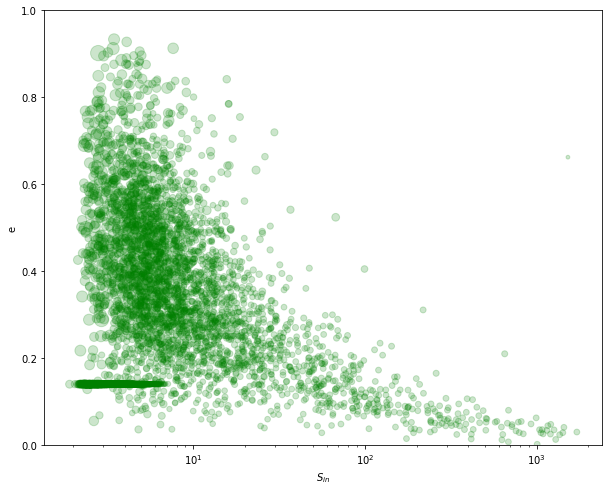

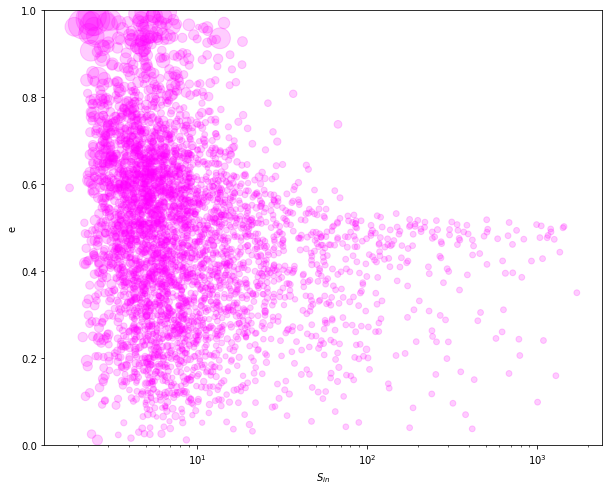

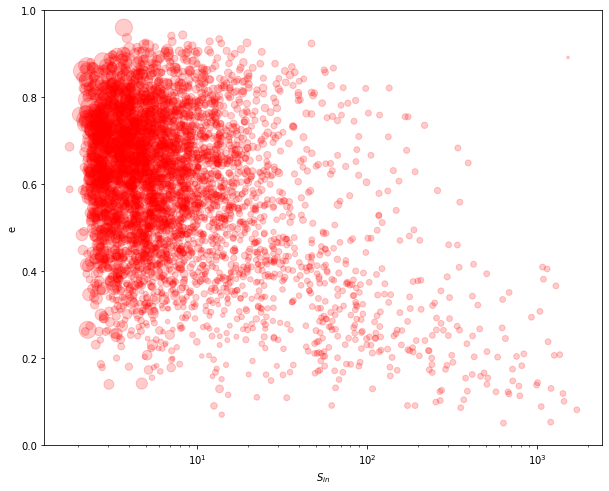

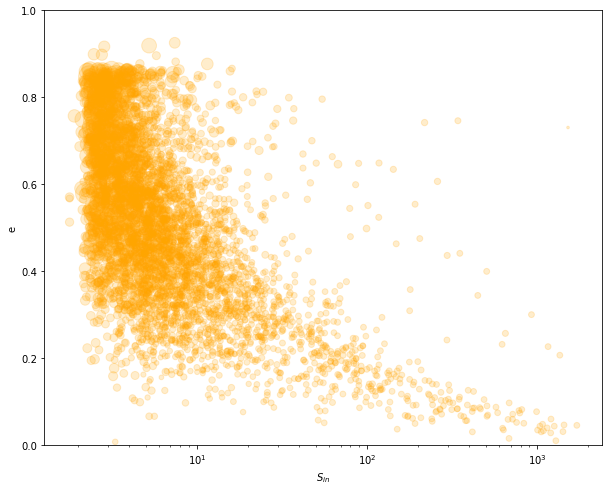

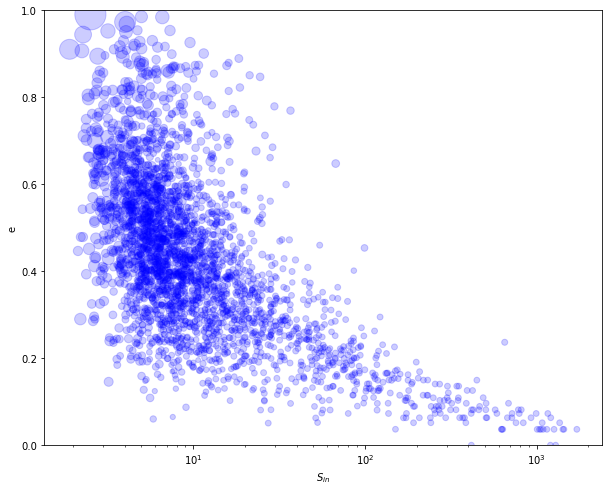

In [3]:
def get_fratio(tag='sim'):
    qt = cluster[tag][(cluster[tag]['injected']>-1000.0*u.mJy)]
    qt.add_column(
        name = 'fratio',
        col = qt['flux_total']/qt['injected']
    )
    qt = qt[(qt['image_type']=='deep')]
    qt.sort('fratio')
    x_min = np.min(qt['fratio'])
    x_max = np.max(qt['fratio'])
    qt.add_column(
        name = 'bubbles',
        col = 1499.0*(qt['fratio']-x_min)/(x_max-x_min)+1
    )
    print(f"[{np.min(qt['bubbles'])},{np.max(qt['bubbles'])}]")
    #print(f"({x_min},{x_max})")
    for source_finder in source_finders:
        fig = plt.figure(figsize=(10,8))
        df = qt[(qt['source_finder']==source_finder)]
        #plt.scatter(df['fratio'],df['eccentricity'],color=colors[source_finder],s=5)
        plt.scatter(df['sn_injected'],df['eccentricity'],color=colors[source_finder],s=df['bubbles'],alpha=0.2)
        #plt.axhline(0.1,color='black',linestyle=":")
        #break
        #plt.xlim((0,10))
        #plt.xlim((0.1,100))
        plt.xscale('log')
        plt.ylim((0,1))
        #plt.ylim((0,10))
        #plt.xlabel("$S_{out}/S_{in}$")
        plt.xlabel("$S_{in}$")
        plt.ylabel("e")

get_fratio()


[1.0,50.0]


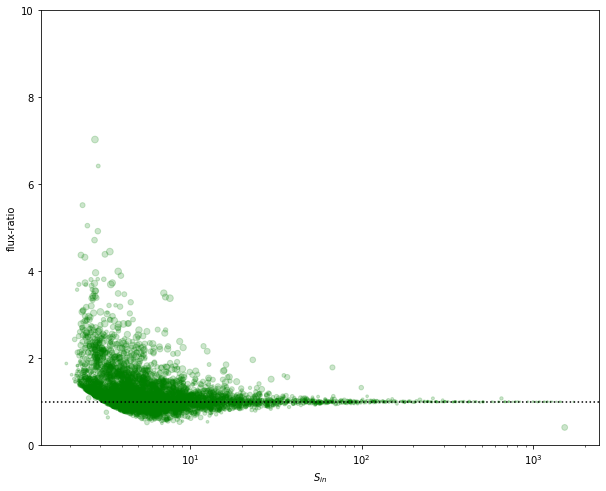

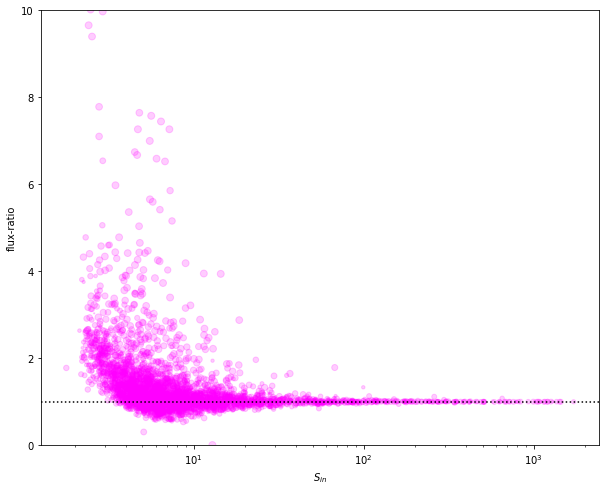

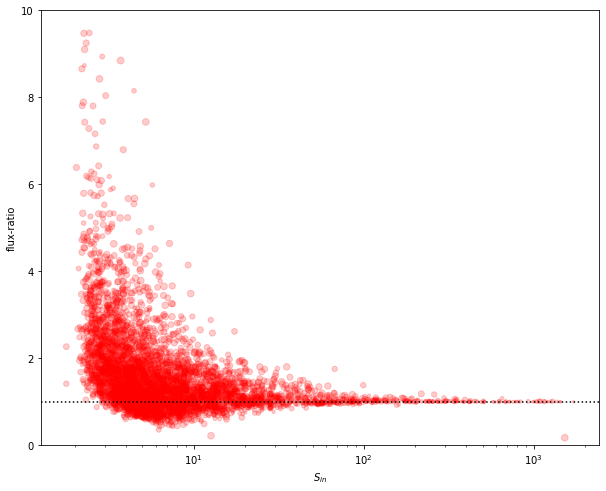

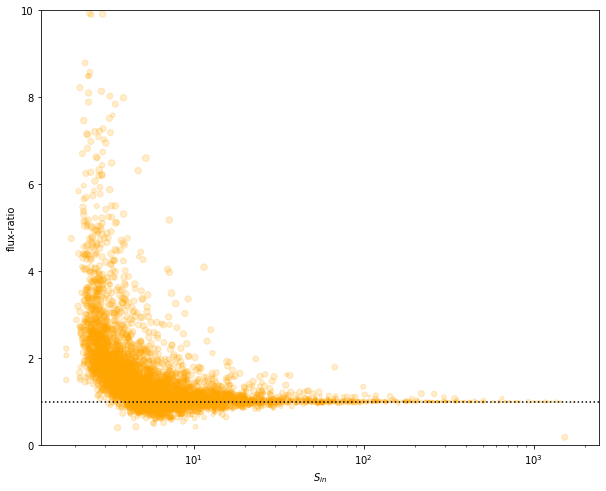

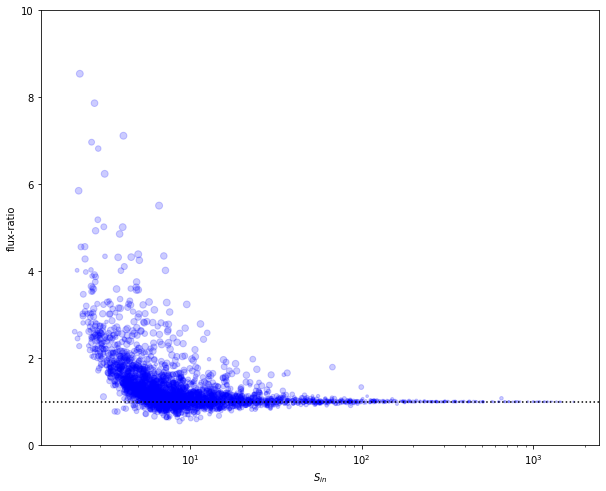

In [509]:
def get_fratiob(tag='sim'):
    qt = cluster[tag][(cluster[tag]['injected']>-1000.0*u.mJy)]
    qt.add_column(
        name = 'fratio',
        col = qt['flux_total']/qt['injected']
    )
    qt.add_column(
        name = 'area',
        col = (np.pi*qt['extent_semimajor']*qt['extent_semiminor']).value
    )
    qt['area'] = [(0.25 if r['source_finder'] in ['aegea','profound'] else 1.0)*r['area'] for r in qt]
    qt = qt[(qt['image_type']=='deep')]
    unit = 'eccentricity'
    #unit = 'area'
    x_min = np.min(qt[unit])
    x_max = np.max(qt[unit])
    qt.add_column(
        name ='bubbles',
        col = (1999 if unit=='area' else 49)*(qt[unit]-x_min)/(x_max-x_min)+1
    )
    print(f"[{np.min(qt['bubbles'])},{np.max(qt['bubbles'])}]")
    for source_finder in source_finders:
        fig = plt.figure(figsize=(10,8))
        df = qt[(qt['source_finder']==source_finder)]
        #plt.scatter(df['fratio'],df['eccentricity'],color=colors[source_finder],s=5)
        plt.scatter(df['sn_injected'],df['fratio'],color=colors[source_finder],s=df['bubbles'],alpha=0.2)
        plt.axhline(1,color='black',linestyle=":")
        #break
        #plt.xlim((0,10))
        #plt.xlim((0.1,100))
        plt.xscale('log')
        plt.ylim((0,10))
        #plt.ylim((0,10))
        #plt.xlabel("$S_{out}/S_{in}$")
        plt.xlabel("$S_{in}$")
        plt.ylabel("flux-ratio")

get_fratiob('sim')


In [ ]:
# {'deep': [3622, 1127, 1056, 2315, 4641], 'shallow': [166, 89, 79, 187, 554]}